In [2]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0%|          | 0.00/199k [00:00<?, ?B/s]
100%|##########| 199k/199k [00:00<00:00, 2.25MB/s]


In [4]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train_data_orig = pd.read_csv('train.csv')
test_data_orig = pd.read_csv('test.csv')

## EDA

In [6]:
train_data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
test_data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

A number of these columns have very few non-null variables compared to the number of entries. I'll drop these columns if more than 20% of the data is missing.

['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

Skew score: 1.883
Kurtosis score: 6.536


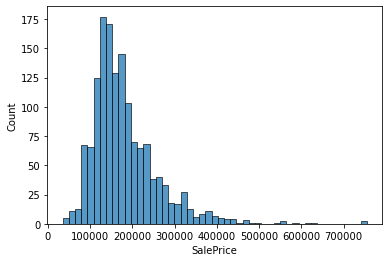

In [17]:
percent_notnull = train_data_orig.count()/len(train_data_orig)
dropped_columns = ['Id']
for col in train_data_orig.columns:
    if percent_notnull[col] < 0.8:
        dropped_columns.append(col)

display(dropped_columns)

train_data = train_data_orig.copy()
train_data = train_data.drop(columns=dropped_columns)
test_data = test_data_orig.copy()
test_data = test_data.drop(columns=dropped_columns)

sns.histplot(train_data['SalePrice']);
print('Skew score: {:.3f}'.format(train_data['SalePrice'].skew()))
print('Kurtosis score: {:.3f}'.format(train_data['SalePrice'].kurt()))

The distribution of our target variable is skewed so we'll try to take a log of the distribution and see if that helps.

Skew score: 0.121
Kurtosis score: 0.810


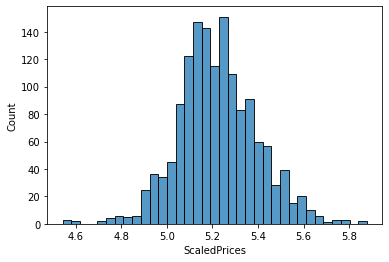

In [18]:
from scipy import stats

train_data['ScaledPrices'] = np.log10(train_data['SalePrice'])
sns.histplot(train_data['ScaledPrices']);
print('Skew score: {:.3f}'.format(train_data['ScaledPrices'].skew()))
print('Kurtosis score: {:.3f}'.format(train_data['ScaledPrices'].kurt()))

Much better. 

In [19]:
# Getting names of numeric and categorical features
numeric_cols = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_cols = train_data.select_dtypes(include='object').columns.tolist()

In [20]:
# Adding some new features based on existing columns
def add_features(data):
    data['TotalSF']    =  data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalBath']  = (data['FullBath'] + (0.5 * data['HalfBath']) +
                          data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
    data['TotalPorch'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                          data['EnclosedPorch'] + data['ScreenPorch'] +
                          data['WoodDeckSF'])
    
add_features(train_data)
add_features(test_data)

MSSubClass 2.1912987626715945 536
LotFrontage 60.0 143
YearRemodAdd 1950 178
MasVnrArea 0.0 861
BsmtFinSF1 0.0 467
BsmtFinSF2 0 1293
2ndFlrSF -0.0 829
LowQualFinSF 0 1434
BsmtHalfBath 0 1378
HalfBath 0 913
KitchenAbvGr 1 1392
WoodDeckSF -0.0 761
OpenPorchSF 0.0 656
EnclosedPorch 0 1252
3SsnPorch 0 1436
ScreenPorch 0 1344
PoolArea 0 1453
MiscVal 0 1408
YrSold 2009 338
GarageArea 0 81


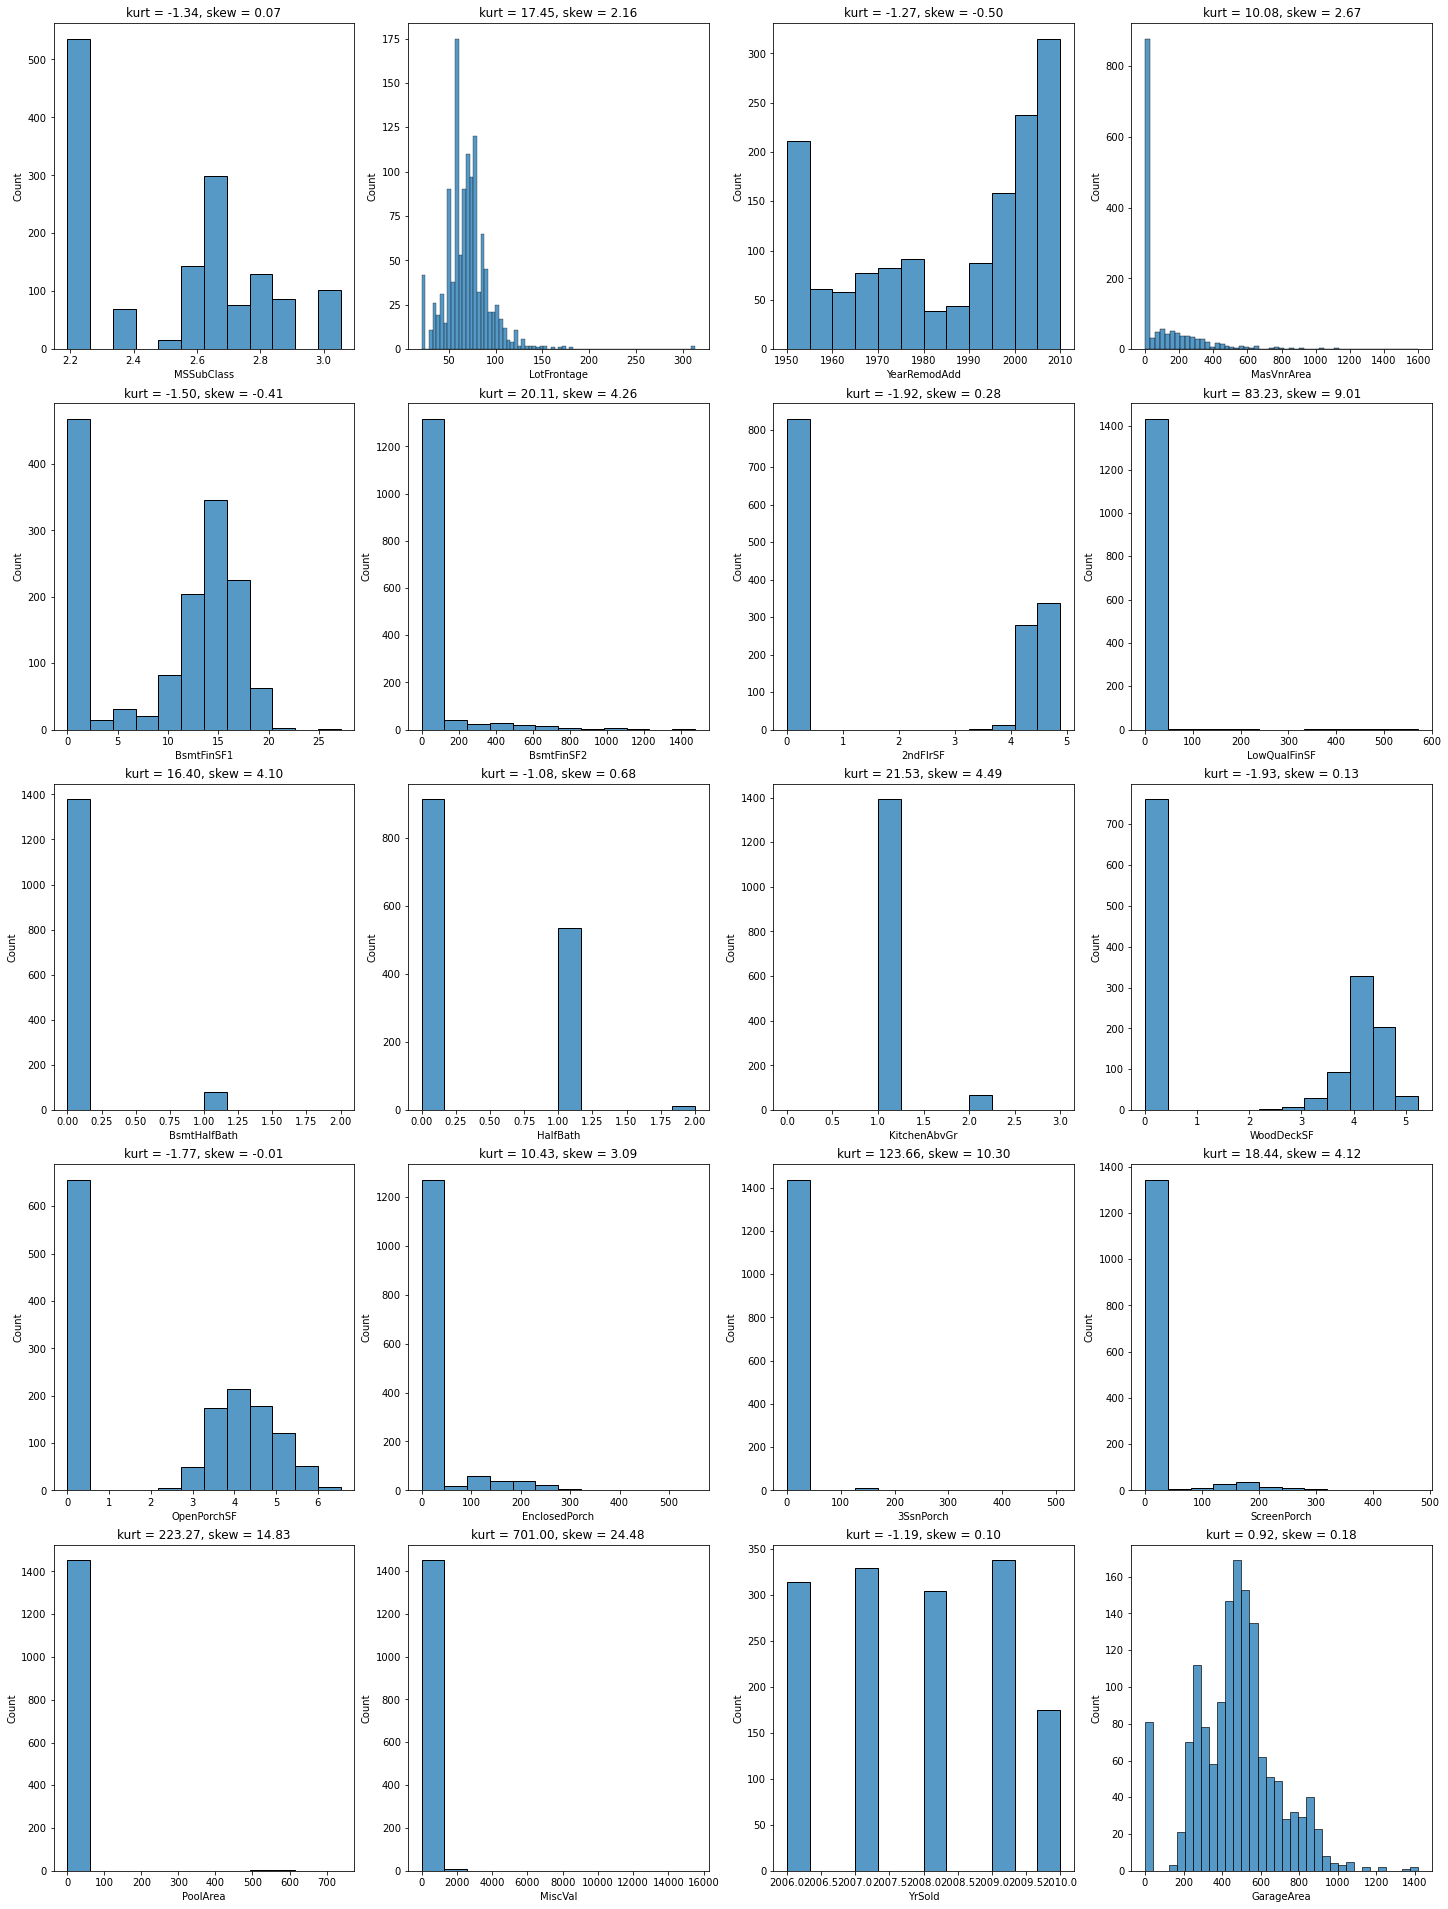

In [21]:
# Checking skew and kurtosis for the rest of the numeric features
skew_kurt_cols = []
fig = plt.figure(figsize=(20,40),constrained_layout=True)
count = 0
for col in numeric_cols:
    to_plot = False
    if abs(train_data[col].skew()) > 0.8:
        tmp = stats.yeojohnson((train_data[col]))[0] # try transform to reduce skew
        if abs(stats.skew(tmp)) < 0.5: # only change the col if this strategy worked
            train_data[col] = tmp
        else:
            skew_kurt_cols.append(col)
            to_plot = True
    if abs(train_data[col].kurt()-3) > 4:
            skew_kurt_cols.append(col)
            to_plot = True
    if to_plot:
        count = count + 1
        ax = fig.add_subplot(8,4,count)
        print(col,train_data[col].value_counts().idxmax(),train_data[col].value_counts().max())
        sns.histplot(train_data[col], ax=ax)
        ax.set_title('kurt = %.2f, skew = %.2f' % (train_data[col].kurt(),train_data[col].skew()))

# Adding this because it becomes clear in later analysis this feature also has many outliers
count = count + 1
col = 'GarageArea'
skew_kurt_cols.append(col)
ax = fig.add_subplot(8,4,count)
print(col,train_data[col].value_counts().idxmax(),train_data[col].value_counts().max())
sns.histplot(train_data[col], ax=ax)
ax.set_title('kurt = %.2f, skew = %.2f' % (train_data[col].kurt(),train_data[col].skew()));

I notice that for all of these the abnormal distributions are due to zeros being entered where there could be nans. For example, if there's no pool, the pool area is entered as zero. Some of these I'm going to leave as-is, and for the others I will add indicator variables. 

In [22]:
safe_cols = ['YrSold','YearRemodAdd','BedroomAbvGrd','HalfBath','BsmtHalfBath',
             'BsmtFullBath','OverallCond','LotArea','LotFrontage','MSSubClass',
             'KitchenAbvGr']
skew_kurt_cols = list(set(skew_kurt_cols)-set(safe_cols))
skew_kurt_cols 

['EnclosedPorch',
 'PoolArea',
 '3SsnPorch',
 'ScreenPorch',
 '2ndFlrSF',
 'MasVnrArea',
 'MiscVal',
 'LowQualFinSF',
 'BsmtFinSF1',
 'GarageArea',
 'BsmtFinSF2',
 'WoodDeckSF',
 'OpenPorchSF']

In [23]:
train_data[skew_kurt_cols] = train_data[skew_kurt_cols].replace(0, np.nan)
test_data[skew_kurt_cols] = test_data[skew_kurt_cols].replace(0, np.nan)
new_cols = []
for col in skew_kurt_cols:
    new_cols.append("_".join([col,"ind"]))

def apply_filt(data,columns,new_columns,filt):
    new_df = pd.DataFrame()
    for col, new_col in zip(columns, new_columns):
        new_df[new_col] = data[col].apply(filt)
    return new_df

indicator = (lambda x: 1 if pd.notna(x) else 0)
train_data = pd.concat([train_data,apply_filt(train_data,skew_kurt_cols,new_cols,indicator)],axis=1)
test_data = pd.concat([test_data,apply_filt(test_data,skew_kurt_cols,new_cols,indicator)],axis=1)

In [24]:
# Again going to drop mostly null columns
percent_notnull = train_data.count()/len(train_data)
dropped_columns = []
for i, col in zip(range(len(train_data.columns)),train_data.columns):
    if percent_notnull[i] < 0.8:
        dropped_columns.append(col)

dropped_columns

['MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 '2ndFlrSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [25]:
train_data = train_data.drop(columns=dropped_columns)
test_data = test_data.drop(columns=dropped_columns)

In [26]:
# This will convert categorical variables into numeric indicator variables, which will increase the # of features
train_new = pd.get_dummies(train_data)
test_new = pd.get_dummies(test_data)

# Drop any columns not present in both datasets
features = list(set(train_new.columns).intersection(set(test_new.columns)))
test_new = test_new[features]
train_new = train_new[features]

print('number of features:', len(features))

number of features: 258


## Feature Selection

Before we can use PCA we will have to impute missing data

In [27]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer

# QuantileTransformer to get as close to a normal distribution as possible for our regression model
train_new = QuantileTransformer().fit_transform(train_new)
train_new = pd.DataFrame(data = KNNImputer().fit_transform(train_new), columns = features)

test_new = QuantileTransformer().fit_transform(test_new)
test_new = pd.DataFrame(data = KNNImputer().fit_transform(test_new), columns = features)

In [28]:
df = pd.concat([train_new, train_data['ScaledPrices']], axis = 1)
correlations = df.corr().apply(lambda x: abs(x))['ScaledPrices'].drop('ScaledPrices')
features_corr_price = correlations[correlations>0.06].sort_values(ascending=False).index.tolist()
correlations.head(20).sort_values(ascending=False)

FullBath                 0.596422
ExterQual_TA             0.595881
TotRmsAbvGrd             0.536396
GarageFinish_Unf         0.432011
Neighborhood_NoRidge     0.277523
HouseStyle_2Story        0.263046
GarageType_BuiltIn       0.222532
KitchenQual_Fa           0.215516
HeatingQC_Fa             0.180613
Foundation_Slab          0.158992
Neighborhood_CollgCr     0.118291
LandContour_Bnk          0.113441
Exterior1st_BrkComm      0.080301
MSZoning_RH              0.072285
SaleCondition_AdjLand    0.064961
Street_Grvl              0.057369
Condition2_Feedr         0.056855
Exterior2nd_ImStucc      0.044922
Foundation_Wood          0.008912
RoofStyle_Mansard        0.005801
Name: ScaledPrices, dtype: float64

In [29]:
from sklearn.decomposition import PCA

#Creating a table with the explained variance ratio
pca = PCA(whiten=True) 
PCdata = pca.fit_transform(train_new)
PCAstats = pd.DataFrame({'standard deviation':np.sqrt(pca.explained_variance_),
                        'explained variance ratio':pca.explained_variance_ratio_,
                        'cumulative variance ratio':np.cumsum(pca.explained_variance_ratio_)})

print(PCAstats)

     standard deviation  explained variance ratio  cumulative variance ratio
0          1.665275e+00              1.575544e-01                   0.157554
1          1.087681e+00              6.721437e-02                   0.224769
2          8.883024e-01              4.483120e-02                   0.269600
3          7.756096e-01              3.417787e-02                   0.303778
4          7.626094e-01              3.304175e-02                   0.336820
5          7.035059e-01              2.811863e-02                   0.364938
6          6.418144e-01              2.340333e-02                   0.388342
7          6.181496e-01              2.170930e-02                   0.410051
8          6.005591e-01              2.049133e-02                   0.430542
9          5.880163e-01              1.964434e-02                   0.450186
10         5.513590e-01              1.727140e-02                   0.467458
11         5.489868e-01              1.712311e-02                   0.484581

Let's see which features contribute most to the first couple PCs.

In [30]:
df_pc1 = pd.DataFrame({'PCA':pca.components_[0], 'feature':train_new.columns})
df_pc1 = df_pc1.sort_values('PCA', ascending=False)
df_pc1.head(10)

,PCA,feature
45,0.234099,Foundation_PConc
33,0.212337,ExterQual_Gd
234,0.190136,HeatingQC_Ex
213,0.184322,KitchenQual_Gd
142,0.181389,Exterior1st_VinylSd
76,0.179603,Exterior2nd_VinylSd
171,0.176701,BsmtQual_Gd
43,0.168150,OpenPorchSF_ind
179,0.151188,BsmtFinType1_GLQ
24,0.150243,YearBuilt


In [31]:
df_pc2 = pd.DataFrame({'PCA':pca.components_[5], 'feature':train_new.columns})
df_pc2 = df_pc2.sort_values('PCA', ascending=False)
df_pc2.head(10)

,PCA,feature
106,0.216954,BsmtFullBath
179,0.216680,BsmtFinType1_GLQ
86,0.207882,BsmtFinSF1_ind
54,0.160298,RoofStyle_Hip
57,0.151436,BsmtQual_Ex
37,0.147995,GarageFinish_Fin
77,0.138167,KitchenQual_Ex
66,0.129642,GarageType_Detchd
176,0.126627,BsmtExposure_Gd
183,0.109868,TotalPorch


Let's visualize the first several PCs.

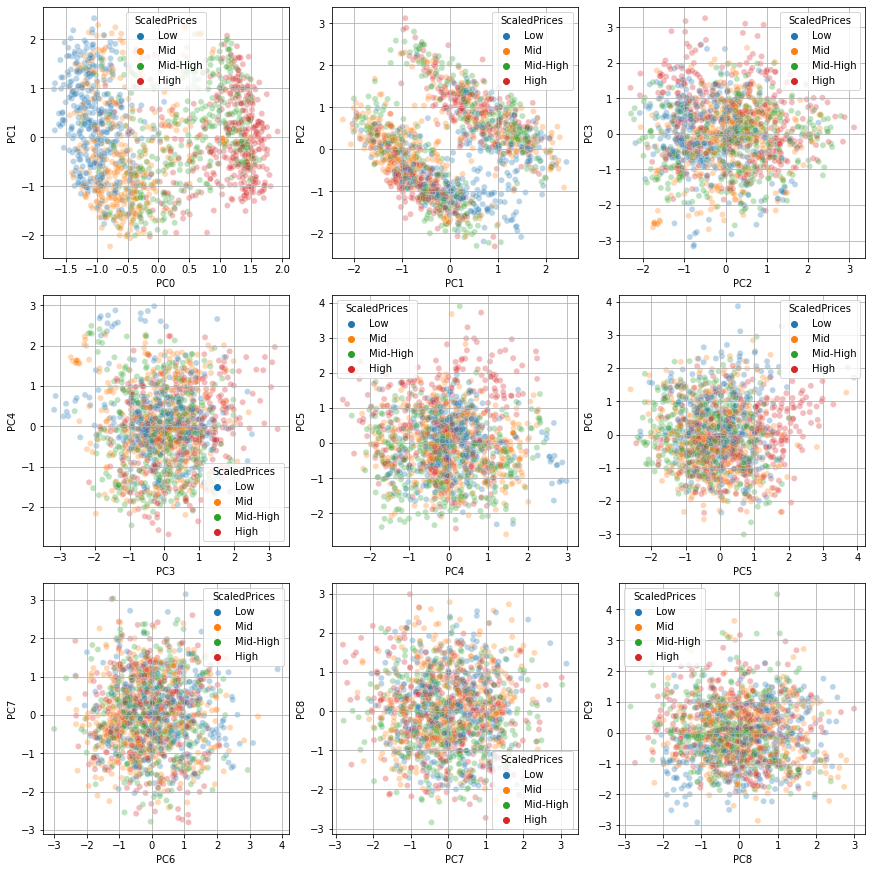

In [33]:
# For labelling data
price_categories = ['Low','Mid','Mid-High','High']
price_tiers = pd.qcut(train_data['ScaledPrices'], len(price_categories), labels=price_categories)

fig = plt.figure(figsize = (12,12),constrained_layout=True)
for i in range(9):
    ax = fig.add_subplot(3,3,i+1) 
    ax.grid(True)
    sns.scatterplot(
        x=PCdata[:,i], y=PCdata[:,i+1],
        hue=price_tiers,
        legend="full",
        alpha=0.3
    )
    ax.set_xlabel('PC%d'%i)
    ax.set_ylabel('PC%d'%(i+1))

In [34]:
# Getting PCs that correlate most with SalePrice
df = pd.concat([pd.DataFrame(data = PCdata), train_data['ScaledPrices']], axis = 1).corr().apply(lambda x: abs(x)).drop('ScaledPrices')
selected_pcs = df['ScaledPrices'].sort_values(ascending=False)
selected_pcs = selected_pcs[selected_pcs>0.04].index.to_list()
print('Top PCs')
df['ScaledPrices'].sort_values(ascending=False)[:30]

Top PCs


0      0.782477
2      0.234240
5      0.224016
3      0.187435
1      0.138782
6      0.135338
9      0.119962
10     0.092496
7      0.081173
23     0.073405
45     0.072939
37     0.070764
4      0.066320
67     0.064229
14     0.059494
21     0.059283
43     0.054812
31     0.052359
27     0.052348
24     0.048879
26     0.048324
94     0.047553
105    0.044763
36     0.044730
70     0.044458
15     0.043648
16     0.042824
11     0.042186
54     0.039531
47     0.039200
Name: ScaledPrices, dtype: float64

In [35]:
# Defining functions to handle features that correlate with each other

def get_correlated_features(corr_matrix,features,thres):
    ls = []
    for feature in features:
        correlations = corr_matrix.loc[features,feature]
        corr_feat = correlations[correlations>thres].index.tolist()
        corr_feat.sort()
        corr_feat.remove(feature) # each feature will correlate with itself
        if corr_feat: 
            # making the assumption that each feature correlates strongly with only one other feature
            tmp = [feature,corr_feat[0]]
            tmp.sort()
            ls.append(tuple(tmp))
    return list(set(ls)) # unique pairs

def remove_correlated_features(features,correlations,correlated_features):
    for pair in correlated_features:
        if correlations[pair[0]] > correlations[pair[1]]:
            try:
                features.remove(pair[1])
            except:
                pass
        else:
            try:
                features.remove(pair[0])
            except:
                pass

In [36]:
# Choose features from the PCs most correlated with price
ls = []
for i in selected_pcs:
    df = pd.DataFrame({'PCA':pca.components_[i], 'feature':train_new.columns})
    df = df.sort_values('PCA', ascending=False) 
    ls.extend(df.iloc[:15,1].values.tolist()) # Top features from each PC
    
features = list(set(ls))

In [37]:
features = list(set(features_corr_price[:50]).union(set(features)))
features.sort()

print('number of features:', len(features))
thres = 0.8

# Next, removing any strongly correlated features
corr_matrix = train_new[features].corr().apply(lambda x: abs(x))   
correlated_features = get_correlated_features(corr_matrix,features,thres)
print('\n Correlated Features:')
display(correlated_features)

# Next, from each pair, remove the feature least correlated with price
df = pd.concat([train_new[features], train_data['ScaledPrices']], axis = 1)
correlations = df.corr().loc[features,'ScaledPrices'].apply(lambda x: abs(x))
remove_correlated_features(features,correlations,correlated_features)
print('\n reduced number of features:', len(features))

# Check for any remaining correlated pairs
correlated_features_new = get_correlated_features(corr_matrix,features,thres) 
if correlated_features_new:
    print('\n Second pass:')
    display(correlated_features_new)
    remove_correlated_features(features,correlations,correlated_features_new)
    print('reduced number of features:', len(features))

number of features: 152

 Correlated Features:


[('ExterQual_Gd', 'ExterQual_TA'),
 ('CentralAir_N', 'CentralAir_Y'),
 ('ExterCond_Gd', 'ExterCond_TA'),
 ('LotShape_IR1', 'LotShape_Reg'),
 ('SaleCondition_Partial', 'SaleType_New'),
 ('Exterior1st_VinylSd', 'Exterior2nd_VinylSd'),
 ('KitchenQual_Gd', 'KitchenQual_TA'),
 ('RoofStyle_Gable', 'RoofStyle_Hip'),
 ('GarageYrBlt', 'YearBuilt'),
 ('MasVnrArea_ind', 'MasVnrType_None'),
 ('MSZoning_RL', 'MSZoning_RM'),
 ('LandSlope_Gtl', 'LandSlope_Mod'),
 ('1stFlrSF', 'TotalBsmtSF'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('Exterior1st_MetalSd', 'Exterior2nd_MetalSd'),
 ('Electrical_FuseA', 'Electrical_SBrkr'),
 ('MSZoning_FV', 'Neighborhood_Somerst'),
 ('GrLivArea', 'TotalSF'),
 ('Exterior1st_HdBoard', 'Exterior2nd_HdBoard'),
 ('BsmtFinSF2_ind', 'BsmtFinType2_Unf'),
 ('2ndFlrSF_ind', 'HouseStyle_1Story'),
 ('Exterior1st_CemntBd', 'Exterior2nd_CmentBd'),
 ('PavedDrive_N', 'PavedDrive_Y'),
 ('Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'),
 ('BsmtFinSF1_ind', 'BsmtFinType1_Unf')]


 reduced number of features: 127


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


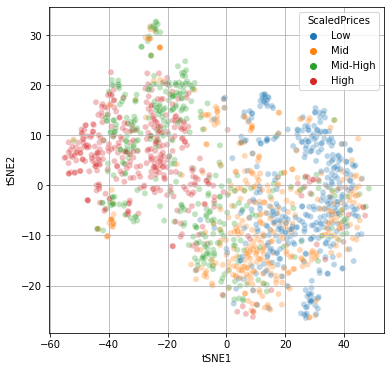

In [39]:

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from matplotlib.cm import get_cmap


tsne = TSNE(perplexity=40,learning_rate='auto',random_state=42)
tSNEdata = tsne.fit_transform(train_new[features])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1) 
ax.grid(True)
sns.scatterplot(
    x=tSNEdata[:,0], y=tSNEdata[:,1],
    hue=price_tiers,
    legend="full",
    alpha=0.3
)
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2');


The t-SNE decomposition is to help us visualize the data to determine if we're headed in the right direction. I'm looking for clustering based on the price tiers I defined earlier. I can see overlapping clusters, the highest and lowest tiers are most defined.

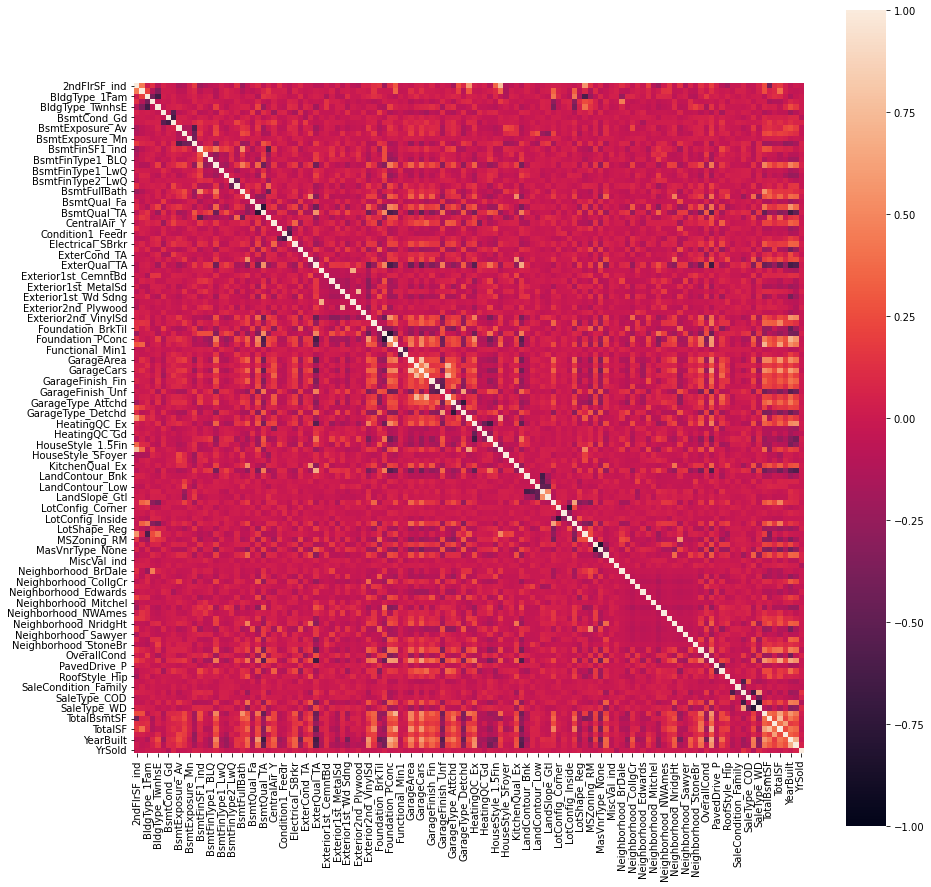

In [40]:
# Plotting correlations between features
plt.figure(figsize=(15,15))
sns.heatmap(train_new[features].corr(),annot=False,square=True, vmin=-1, vmax=1);

## Training

In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

X = train_new[features]
X_sub = test_new[features]
y = train_data['ScaledPrices']

model = XGBRegressor(max_depth=3,
                     learning_rate=0.1,
                     n_estimators=500,
                     min_child_weight=1,
                     gamma=0,
                     colsample_bytree=0.5,
                     subsample=0.8,
                     eval_metric=["rmse", "logloss"],
                     random_state=42)

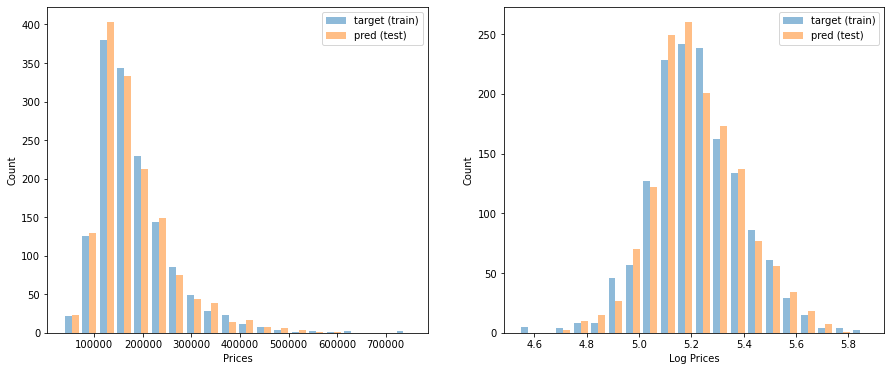

In [46]:
model.fit(X,y)
predictions = 10**(model.predict(X_sub))

# Comparing the distribution of predictions against the distribution from the train set
# If we expect the train and test sets to come from the same distribution, this is a decent sanity check.
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1)
plt.hist([10**train_data['ScaledPrices'].values, predictions], color=['tab:blue','tab:orange'], alpha=0.5,bins=20);
plt.legend(['target (train)','pred (test)']);
ax.set_xlabel('Prices')
ax.set_ylabel('Count')
ax = fig.add_subplot(1,2,2)
plt.hist([train_data['ScaledPrices'].values, np.log10(predictions)], color=['tab:blue','tab:orange'], alpha=0.5,bins=20);
plt.legend(['target (train)','pred (test)']);
ax.set_xlabel('Log Prices')
ax.set_ylabel('Count');

In [45]:
output = pd.DataFrame({'Id': test_data_orig.Id, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Successfully saved!")

Successfully saved!
